<a href="https://colab.research.google.com/github/Ahmad-Khaled/Keras_Classification/blob/master/Behavioral_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Ahmad-Khaled/TrackUpdate4.git

fatal: destination path 'TrackUpdate4' already exists and is not an empty directory.


In [0]:
!ls TrackUpdate4

'Default Windows desktop 64-bit_Data'   driving_log.csv
'Default Windows desktop 64-bit.exe'    IMG


In [0]:
!pip uninstall tensorflow
!pip install tensorflow
!pip3 install imgaug


Uninstalling tensorflow-2.0.0:
  Would remove:
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.0.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.0.0
  Using cached https://files.pythonhosted.org/packages/46/0f/7bd55361168bb32796b360ad15a25de6966c9c1beb58a8e30c01c8279862/tensorflow-2.0.0-cp36-cp36m-manylinux2010_x86_64.whl


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath 
import random
import datetime


In [0]:
print(tf.__version__)
%load_ext tensorboard

!rm -rf ./logs/ 

2.0.0


In [0]:

datadir = 'TrackUpdate4'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)


In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center']  = data['center'].apply(path_leaf)
data['left']  = data['left'].apply(path_leaf)
data['right']  = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2019_11_09_12_04_14_302.jpg  ...  0.000067
1  center_2019_11_09_12_04_14_416.jpg  ...  0.000068
2  center_2019_11_09_12_04_14_528.jpg  ...  0.000068
3  center_2019_11_09_12_04_14_635.jpg  ...  0.000069
4  center_2019_11_09_12_04_14_747.jpg  ...  0.000068

[5 rows x 7 columns]

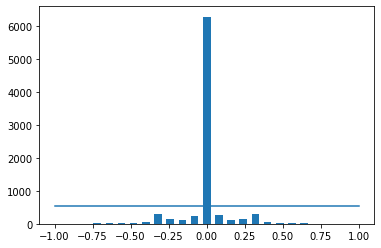

In [0]:
num_bins = 25
samples_per_bin = 550
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data:  8172
removed 5724
remaining:  2448


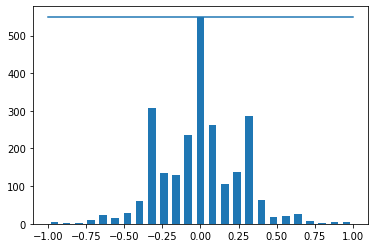

In [0]:
print('total data: ', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    # Working only with the center images
    # Appending them to the list called image_path
    image_path.append(os.path.join(datadir, center.strip())) # .strip strips out the spaces in the directory (if present)
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

# image_paths is an array of images directories 
# steerings: for steering values required for regression
images_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(images_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1958
Valid Samples: 490


Text(0.5, 1.0, 'Validation Set')

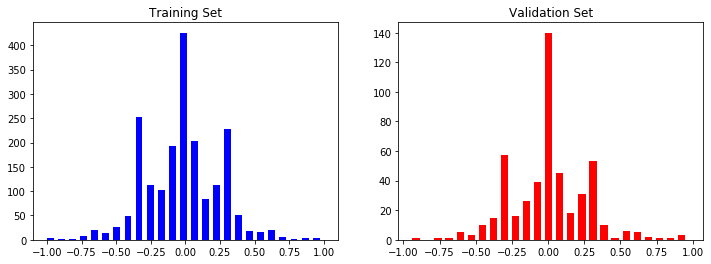

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training Set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation Set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3)) #affine transformations include scaling
  #start range with 1 (no zoom) to 1.3 (30% zoom) 
  #it selects random zoom within the defined range for each augmented image
  image = zoom.augment_image(image)
  return image

Text(0.5, 1, 'Zoomed Images')

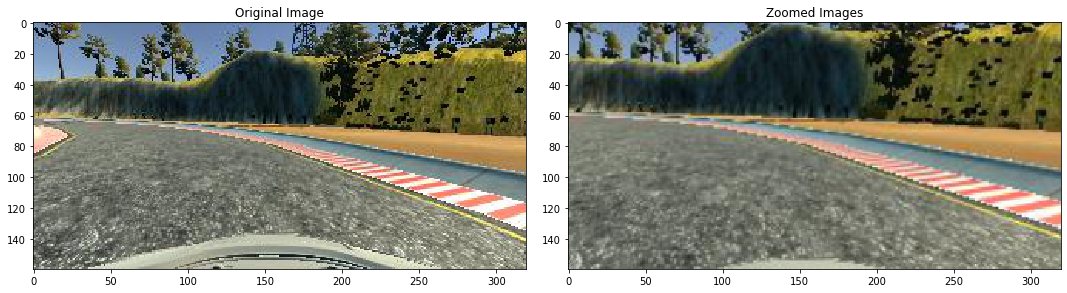

In [0]:
image = images_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Images')

In [0]:
def pan(image):
  # 10% translation (left and right), (up and down)
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1, 'Panned Images')

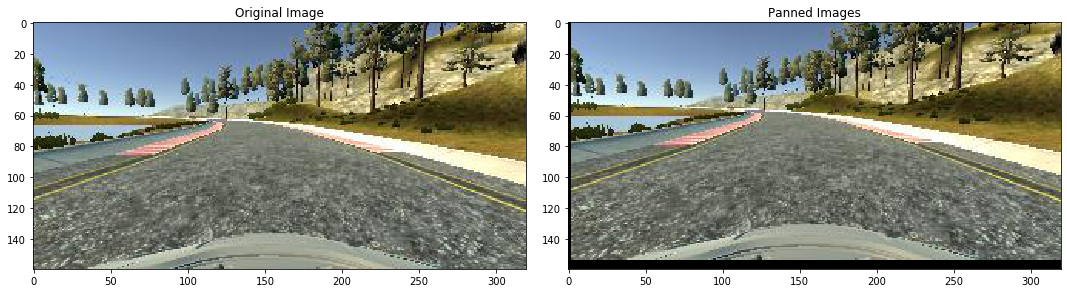

In [0]:
image = images_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Images')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2)) 
  # multiplies all the pixel intensities inside the image
  # thus any pixel instensity multiplied by a value less than 1 will become darker
  # from experience: models react better with darker images 
  image = brightness.augment_image(image)
  return image 

Text(0.5, 1, 'Brightness Altered Image Images')

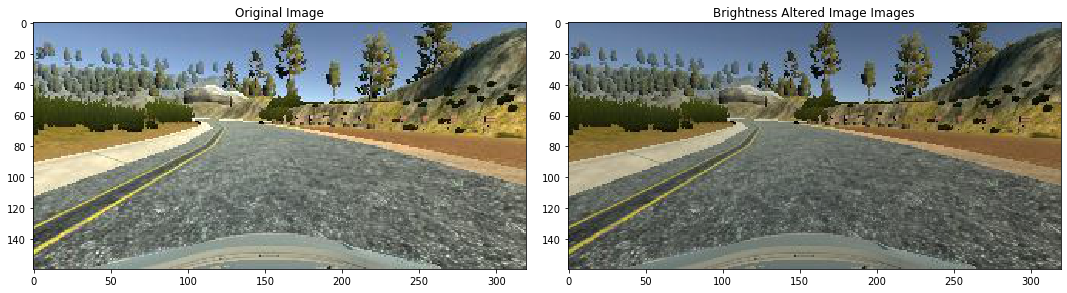

In [0]:
image = images_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image Images')

In [0]:
# flipping adds more balancing to the steering data
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1) # using 1 flips the image horizontally
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1, 'Flipped Image -Steering Angle: -0.3028509')

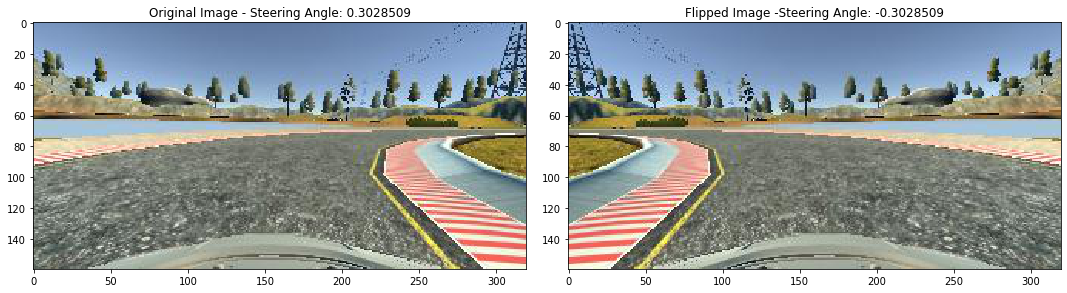

In [0]:
random_index = random.randint(0, 1000)
image = images_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10)); fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle: '+ str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image -' + 'Steering Angle: ' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)

  return image, steering_angle
    

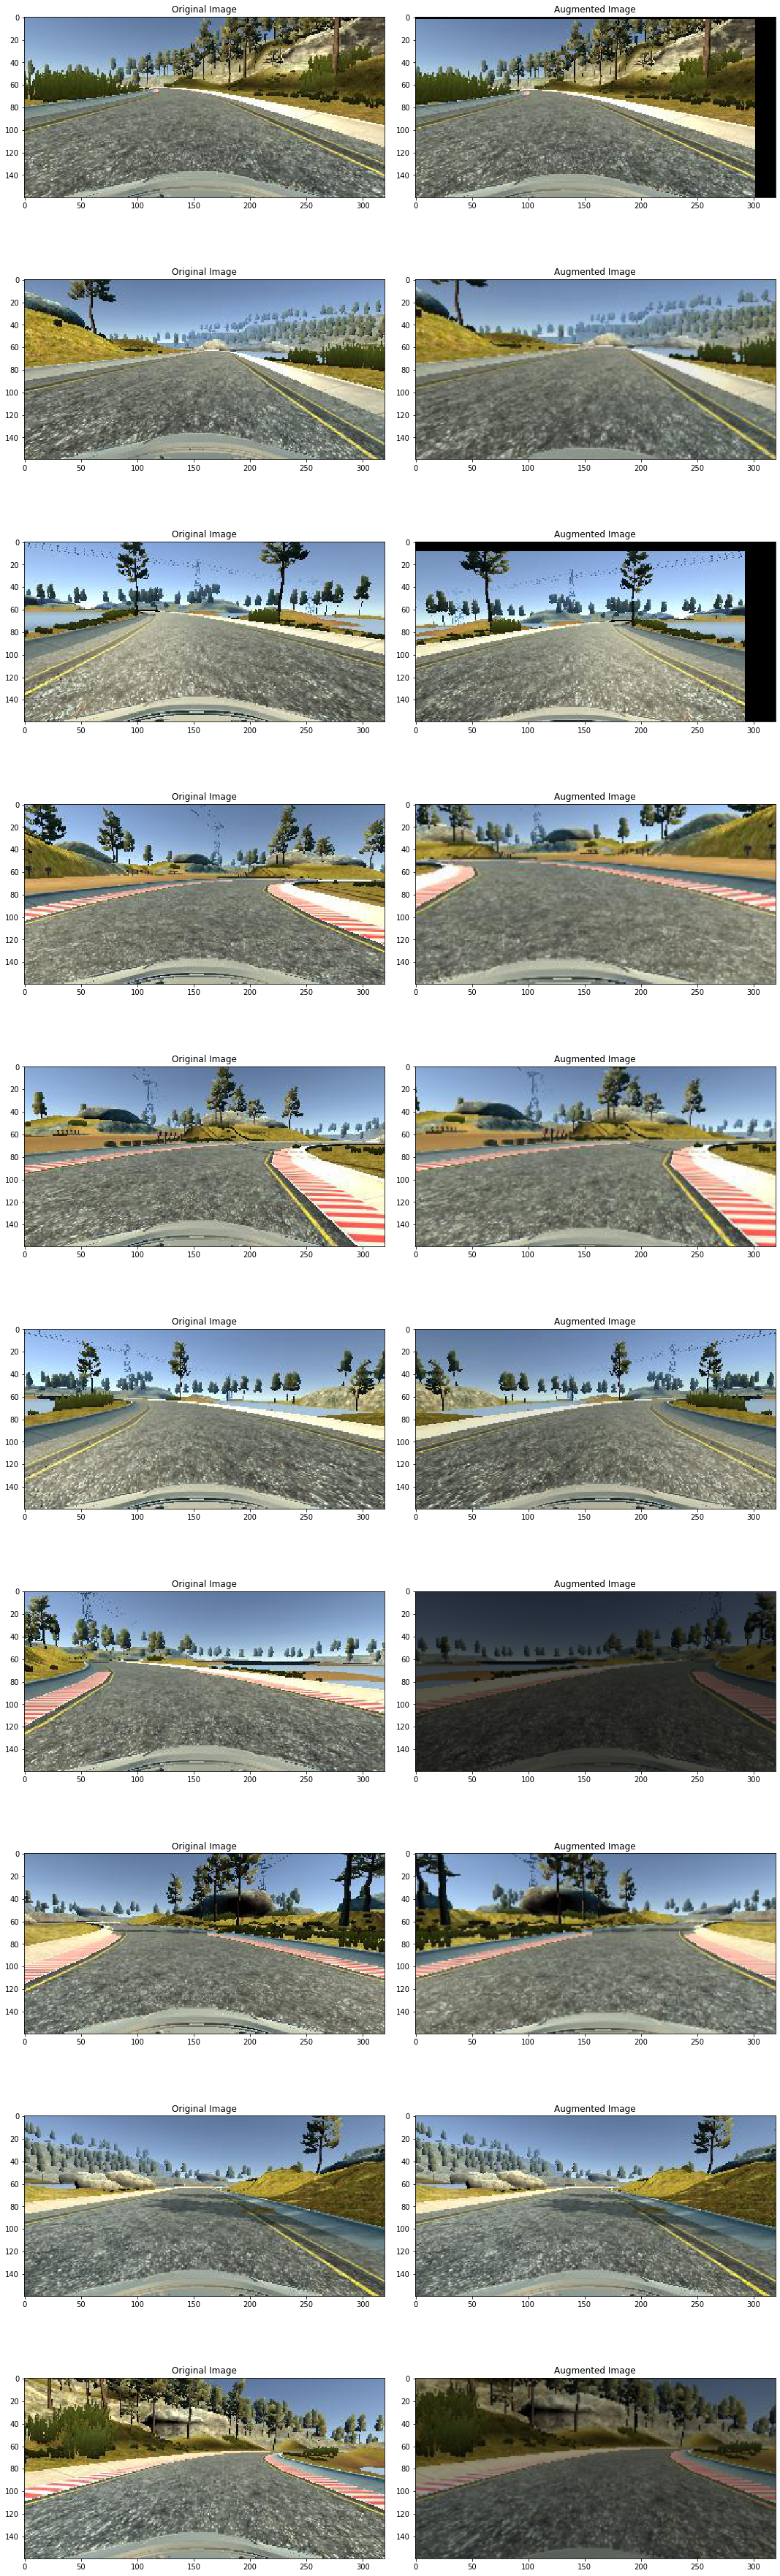

In [0]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(images_paths) - 1)
  random_image = images_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')
  

In [0]:
def image_preprocess(img):
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1, 'Preprocessed Image')

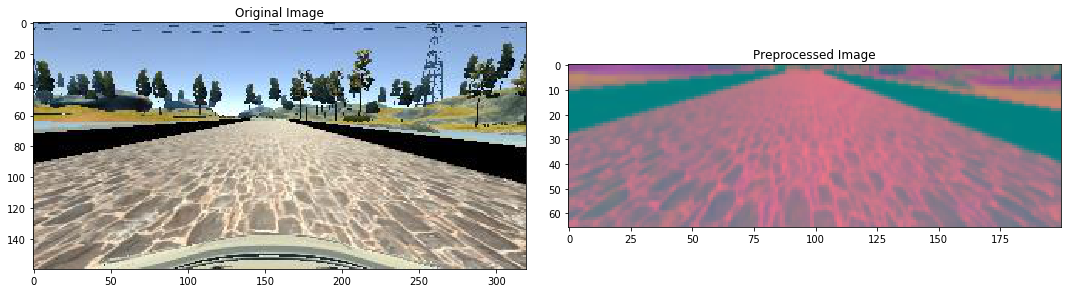

In [0]:
image = images_paths[120]
original_image = mpimg.imread(image)
preprocessed_image = image_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image); axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image); axs[1].set_title('Preprocessed Image')

In [0]:
def batch_generator(images_paths, steering_angle, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(images_paths) - 1)

      if istraining: 
        im, steering = random_augment(images_paths[random_index], steering_angle[random_index])
        
      else:
        im = mpimg.imread(images_paths[random_index])
        steering = steering_angle[random_index]

      im = image_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  




Text(0.5, 1, 'Validation Data')

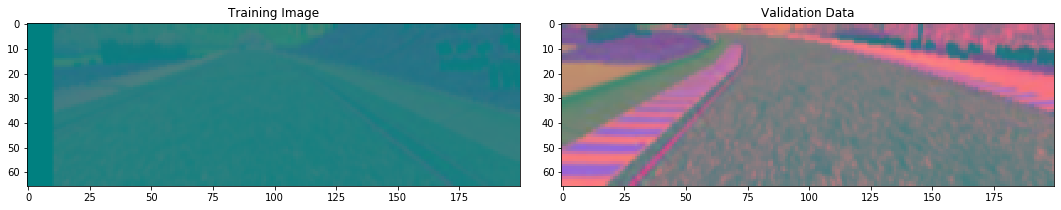

In [0]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_train, y_train, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation Data')

In [0]:
def nvidia_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(24, (5, 5), strides=2, input_shape=(66, 200, 3), activation='elu')) 
  # subsample=(2, 2)=(move horizontally with a stride of 2, move vertically 2 pixels)
  model.add(tf.keras.layers.Conv2D(36, (5, 5), strides=2, activation='elu'))
  model.add(tf.keras.layers.Conv2D(48, (5, 5), strides=2, activation='elu'))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))

  model.add(tf.keras.layers.Conv2D(64, 3, 3, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Flatten())
  
  model.add(tf.keras.layers.Dense(100, activation='elu'))
  # model.add(Dropout(0.5))


  model.add(tf.keras.layers.Dense(50, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(tf.keras.layers.Dense(10, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(tf.keras.layers.Dense(1))
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(0.001))
  return model
  


In [0]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 6, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               3

In [0]:
# Since we'll be dealing with a huge augmented dataset, we must generate it on the fly, in batches, with the generator we just created.
# Thus we also require fit_generator() rather than fit()
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                steps_per_epoch=300,
                                epochs=10,
                                validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                validation_steps=200,
                                verbose=1,
                                shuffle=1,
                                callbacks=[tf.keras.callbacks.TensorBoard(log_dir="logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))]
                              )

Epoch 1/10
300/300 [==============================] - 584s 2s/step - loss: 0.0796 - val_loss: 0.0406
Epoch 2/10
300/300 [==============================] - 585s 2s/step - loss: 0.0500 - val_loss: 0.0427
Epoch 3/10
300/300 [==============================] - 586s 2s/step - loss: 0.0464 - val_loss: 0.0365
Epoch 4/10
300/300 [==============================] - 574s 2s/step - loss: 0.0431 - val_loss: 0.0328
Epoch 5/10
300/300 [==============================] - 568s 2s/step - loss: 0.0388 - val_loss: 0.0304
Epoch 6/10
300/300 [==============================] - 569s 2s/step - loss: 0.0372 - val_loss: 0.0302
Epoch 7/10
300/300 [==============================] - 572s 2s/step - loss: 0.0353 - val_loss: 0.0297
Epoch 8/10
300/300 [==============================] - 581s 2s/step - loss: 0.0341 - val_loss: 0.0286
Epoch 9/10
300/300 [==============================] - 590s 2s/step - loss: 0.0333 - val_loss: 0.0286
Epoch 10/10
300/300 [==============================] - 585s 2s/step - loss: 0.0329 - val_lo

Text(0.5, 0, 'Epoch')

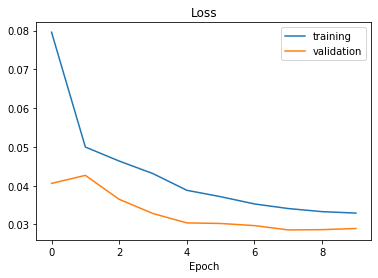

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:

%tensorboard --logdir logs/fit


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/main.py", line 59, in run_main
    default.get_plugins() + default.get_dynamic_plugins(),
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/default.py", line 110, in get_dynamic_plugins
    for entry_point in pkg_resources.iter_entry_points('tensorboard_plugins')
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/default.py", line 110, in <listcomp>
    for entry_point in pkg_resources.iter_entry_points('tensorboard_plugins')
  File "/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py", line 2442, in load
    self.require(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py", line 2465, in require
    items = working_set.resolve(reqs, env, installer, extras=self.extras)
  Fil

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# from google.colab import files
# files.download('model.h5')